In [1]:

import sys
sys.path.append("../")  

import numpy as np 
import torch, time
import torch.nn.functional as F
import torch.nn as nn
from scipy.linalg import lstsq
import matplotlib.pyplot as plt
import problem, net
import random

def set_seed(seed=42):
    random.seed(seed)             # Python 内置随机数种子
    np.random.seed(seed)          # NumPy 随机数种子
    torch.manual_seed(seed)       # PyTorch CPU 随机数种子
    torch.cuda.manual_seed(seed)  # PyTorch GPU 随机数种子
    torch.cuda.manual_seed_all(seed)  # 多 GPU 训练时设定所有 GPU 相同种子
    torch.backends.cudnn.deterministic = True  # 保证 CUDA 计算的确定性
    torch.backends.cudnn.benchmark = False  # 关闭自动优化（可能影响速度）

plt.rcParams.update({
    'font.size': 20,
})

# 设置随机种子
set_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
torch.set_default_dtype(torch.float64)

def u_exact(x):
    if x.ndim == 1:
        x1 = x[0]
        x2 = x[1]
    else:
        x1 = x[:,0]
        x2 = x[:,1]
    return torch.sin(torch.pi * x1) * torch.sin(torch.pi * x2)

def f(x):
    if x.ndim == 1:
        x1 = x[0]
        x2 = x[1]
    else:
        x1 = x[:,0]
        x2 = x[:,1]
    return 2 * torch.pi**2 * torch.sin(torch.pi * x1) * torch.sin(torch.pi * x2)


In [3]:
def trainnew(model,problem,device,params,optimizer):
    
    Pix = 200
    x = torch.arange(-1,1+1/Pix,2/Pix)
    y = torch.arange(-1,1+1/Pix,2/Pix)
    TestData = torch.zeros([(Pix+1)**2,params["d"]]).to(device)


    X,Y = torch.meshgrid(x,y)

    XX = X.reshape(-1,1)
    YY = Y.reshape(-1,1)
    XX = XX.squeeze()
    YY = YY.squeeze()
    TestData[:,0] = XX
    TestData[:,1] = YY

    TestData.requires_grad = True
    
    model.train()
    
    problem.generate_points(params["bodyBatch"], params["bdryBatch"], "random")
    int_data = problem.data()["interior_points"]
    bdry_data = problem.data()["boundary_points"]
    int_data.requires_grad = True
    bdry_data.requires_grad = True
    
    for step in range(params["trainStep"]):
        u = model(int_data)[1]
        u_second = model(int_data)[0]
        u_bdry = model(bdry_data)[1]
        
        model.zero_grad()
        dudxy = torch.autograd.grad(u,int_data,grad_outputs=torch.ones_like(u),retain_graph=True,create_graph=True,only_inputs=True,allow_unused=True)[0]
        loss_int = torch.mean(0.5*(dudxy[:,0]**2+dudxy[:,1]**2)-u*(f(int_data).reshape(-1,1)))
        loss_bdry = (u_bdry.reshape(-1,1)).pow(2).mean()
        loss_orthogonal = torch.norm(u_second.T @ u_second - torch.eye(params["width"]).to(device).double(), p='fro')
        loss = loss_int + 500 * loss_bdry + params["orthogonalpenalty"] * loss_orthogonal

        if step%params["writeStep"] == params["writeStep"]-1:
            print("Error at Step %s is %s."%(step+1,loss))
            
        
        if step%params["plotStep"] == params["plotStep"]-1:
            tem = lambda x: model(x)[1]
            problem.plot(tem)
        

        loss.backward()
        optimizer.step()
        
    (A, rhs) = problem.leastsquareproblem(model, int_data, bdry_data)
    w, _, _, _ = lstsq(A, rhs)
    U, s, Vh = torch.linalg.svd(u_second.T@u_second)
    error = A @ w - rhs
    threshold = 1e-3
    effective_rank = (s > threshold).sum()
    print("the error of least square in problem " + str(problem.name)+": ", np.mean(np.abs(error)))
    print("the effective rank of basis in problem %s is %s with threshold %s" % (str(problem.name), effective_rank.detach().cpu().numpy(), threshold))
    perdict = lambda x: torch.matmul(model(x)[0], torch.tensor(w).to(device))
    problem.plot(perdict)
    return 0

c:\Users\29433\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
c:\Users\29433\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\autograd\graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Error at Step 50 is tensor(41.1763, device='cuda:0', grad_fn=<AddBackward0>).
Error at Step 100 is tensor(25.2625, device='cuda:0', grad_fn=<AddBackward0>).
Error at Step 150 is tensor(23.3583, device='cuda:0', grad_fn=<AddBackward0>).
Error at Step 200 is tensor(22.7818, device='cuda:0', grad_fn=<AddBackward0>).
Error at Step 250 is tensor(22.4632, device='cuda:0', grad_fn=<AddBackward0>).
Error at Step 300 is tensor(22.1717, device='cuda:0', grad_fn=<AddBackward0>).
Error at Step 350 is tensor(21.8737, device='cuda:0', grad_fn=<AddBackward0>).
Error at Step 400 is tensor(21.5923, device='cuda:0', grad_fn=<AddBackward0>).
Error at Step 450 is tensor(21.3634, device='cuda:0', grad_fn=<AddBackward0>).
Error at Step 500 is tensor(21.1958, device='cuda:0', grad_fn=<AddBackward0>).
the l2 relative error in problem poisson2d:  0.7377521708442975
the maximum pointwise error in problem poisson2d:  0.7823499337670498


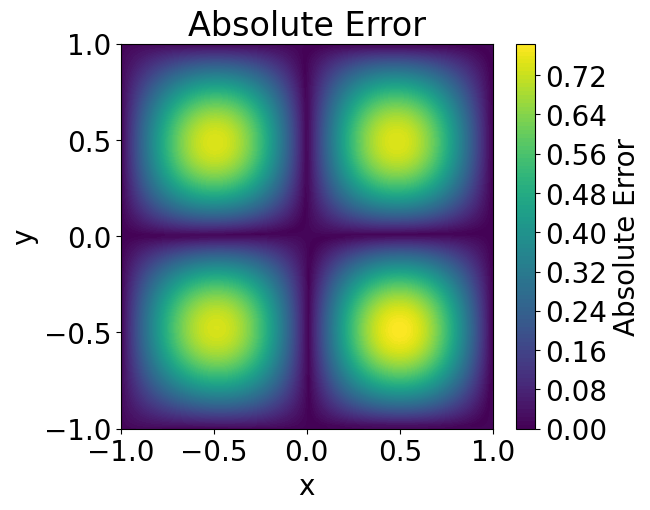

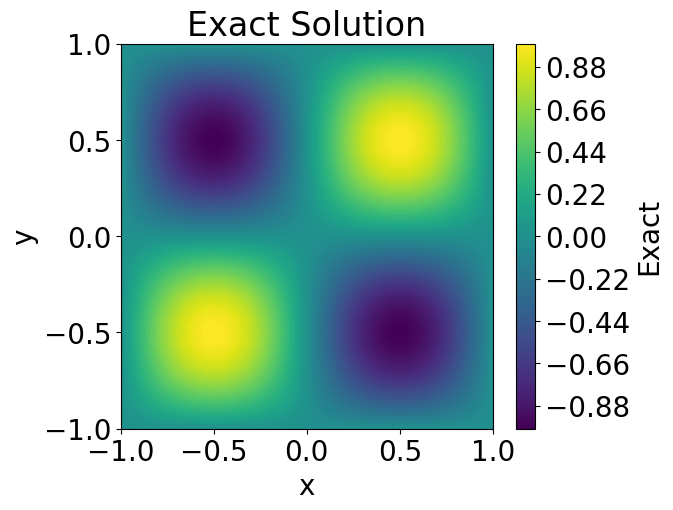

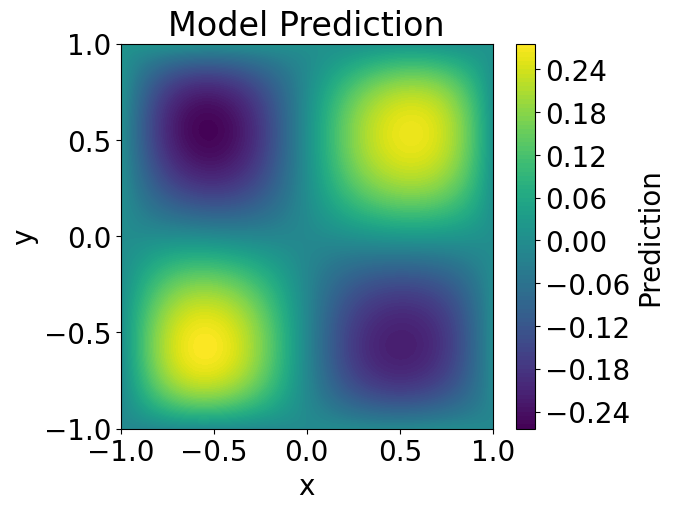

the error of least square in problem poisson2d:  4.0310516904123384e-07
the effective rank of basis in problem poisson2d is 41 with threshold 0.001
the l2 relative error in problem poisson2d:  1.6323931941825824e-09
the maximum pointwise error in problem poisson2d:  1.1364911102484943e-08


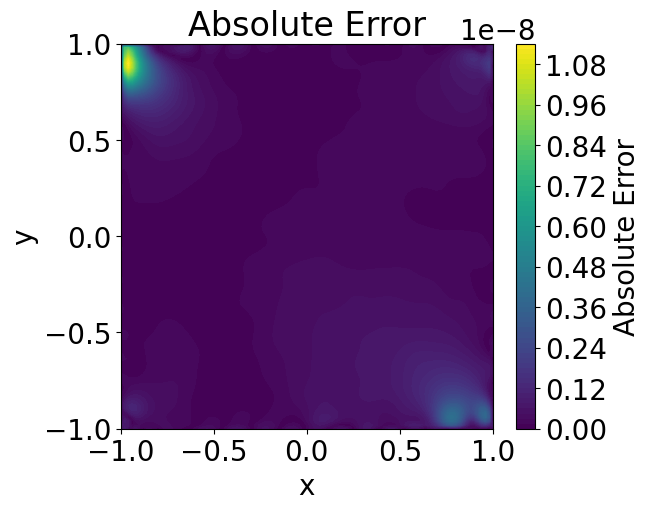

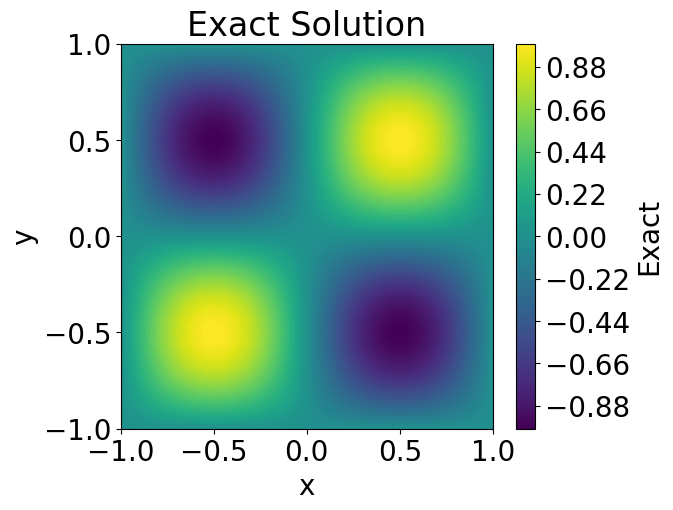

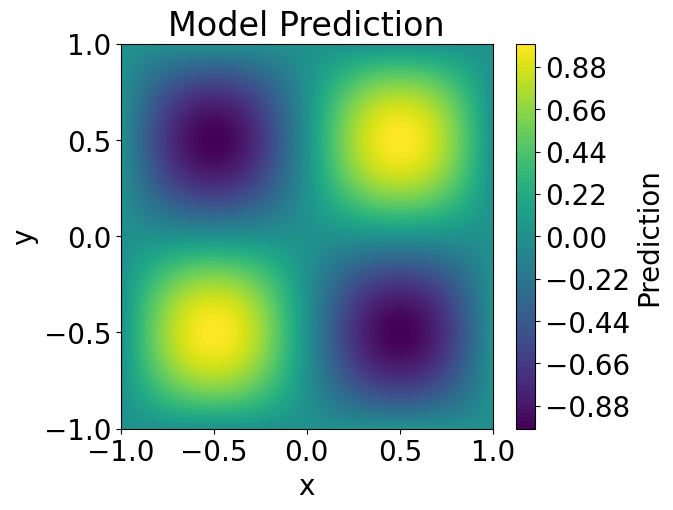

0

In [4]:
Pro = problem.PoissonBox(f, u_exact, u_exact, domain_size=1)

params = {"dd":1, "d": 2, "bodyBatch": 1024, "bdryBatch": 400, "lr": 0.001, "width": 500, "depth":2, "trainStep": 500, "writeStep": 50, "plotStep": 500, "decay": 0.0001, "epsilon": 1e-17, "orthogonalpenalty": 1}


startTime = time.time()
model = net.PD_OFM(params, connection="residual", initialization="xavier").to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=params["lr"], weight_decay=params["decay"])

startTime = time.time()
trainnew(model,Pro,device,params,optimizer)  #trainnew model
